# Modelling Stage

## Libraries and directories

In [19]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

In [20]:
# Directory for transformed data
transformed_data_path = './Transformed_data/'

#Load dataset
full_db_prep =  pd.read_pickle(transformed_data_path+'tennis_db_preprocessed.pkl')

# Load predictors' name
with open("predictors.json", "r") as f:
    predictors = json.load(f)

# Load predictors' description
with open("predictors_description.json", "r") as f:
    variables_index = json.load(f)


numerical_variables = [x for x in predictors if 'Diff' in x ]
categorical_variables = [x for x in predictors if 'Diff' not in x ]
target = ['Win_indicator']

# Set seed
seed = 2024

## Data split

In [21]:
############ Data Split

# Use <= 2019 for traing and >2019 for testing
year_split = 2019
idx_split = full_db_prep['Season']<=year_split
n_size = full_db_prep.shape[0]
full_db_prep['Sample'] = np.where(idx_split,'Train','Test')

# Total Sample details
print('**** Total sample ****')
print('Size:',full_db_prep.shape)
print(f'Size %: {round(len(full_db_prep)*100/n_size,2)}%')
print(f'Winning rate: {round(full_db_prep['Win_indicator'].mean()*100,2)}%')
print(f"Full date range: {full_db_prep['tourney_date'].min()} → {full_db_prep['tourney_date'].max()}")
print('___________________________________________\n')

# Train sample details
X_train = full_db_prep[idx_split][predictors].reset_index(drop=True)
y_train = full_db_prep[idx_split][target].reset_index(drop=True)

print('**** Train sample ****')
print('Size:',X_train.shape)
print(f'Size %: {round(len(X_train)*100/n_size,2)}%')
print(f'Winning rate: {round(np.mean(y_train)*100,2)}%')
print(f"Train date range: {full_db_prep[idx_split]['tourney_date'].min()} → {full_db_prep[idx_split]['tourney_date'].max()}")
print('___________________________________________\n')

# Test sample details
X_test = full_db_prep[~idx_split][predictors].reset_index(drop=True)
y_test = full_db_prep[~idx_split][target].reset_index(drop=True)

print('**** Test sample ****')
print('Size:',X_test.shape)
print(f'Size %: {round(len(X_test)*100/n_size,2)}%')
print(f'Winning rate: {round(np.mean(y_test)*100,2)}%')
print(f"Test date range: {full_db_prep[~idx_split]['tourney_date'].min()} → {full_db_prep[~idx_split]['tourney_date'].max()}")

**** Total sample ****
Size: (13081, 64)
Size %: 100.0%
Winning rate: 50.14%
Full date range: 19990118 → 20240826
___________________________________________

**** Train sample ****
Size: (10668, 14)
Size %: 81.55%
Winning rate: 50.25%
Train date range: 19990118 → 20190826
___________________________________________

**** Test sample ****
Size: (2413, 14)
Size %: 18.45%
Winning rate: 49.65%
Test date range: 20200120 → 20240826


## Final Data treatments

### Treatment for missing values

In [22]:
## Impute median for numerical variables:

#Define X_train and X_test datasets
X_train_num = X_train[numerical_variables]
X_test_num = X_test[numerical_variables]
X_train_cat = X_train[categorical_variables]
X_test_cat = X_test[categorical_variables]

# Only for Diff_minutes and Diff_height which have missing values, imput the median
imputer = SimpleImputer(strategy='median').fit(X_train_num) #Computes the median using the training sample


X_train_num = pd.DataFrame(
    imputer.transform(X_train_num),
    columns=numerical_variables) #Apply imput values for traing sample

X_test_num = pd.DataFrame(
    imputer.transform(X_test_num), #Apply imput values for test sample
    columns=numerical_variables)

# Input Unknown as Right-Handed for categorical variable
X_train_cat.loc[:,'Hand_Type'] = np.where(X_train_cat['Hand_Type'].isin(['Unknown']),'Right-handed',X_train_cat['Hand_Type'])
X_test_cat.loc[:,'Hand_Type'] = np.where(X_test_cat['Hand_Type'].isin(['Unknown']),'Right-handed',X_test_cat['Hand_Type'])

### Standarization for variables

In [23]:
# Normal standarisation for numerical variables to perform statiscal tests of variable importance
scaler = StandardScaler().fit(X_train_num)  # fit only using Train sample and apply in both samples
X_train_num_std = pd.DataFrame(scaler.transform(X_train_num),columns=numerical_variables)
X_test_num_std = pd.DataFrame(scaler.transform(X_test_num),columns=numerical_variables)

# Creation of dummy variables for categorical variables
X_train_dummy = pd.get_dummies(X_train_cat,drop_first=True,columns = None, prefix='',dtype=int)
X_train_dummy.columns = X_train_dummy.columns.str.lstrip('_')
X_test_dummy = pd.get_dummies(X_test_cat,drop_first=True,columns = None, prefix='',dtype=int)
X_test_dummy.columns = X_test_dummy.columns.str.lstrip('_')

# Final database setting
X_train_vf = pd.concat([X_train_num_std,X_train_dummy],axis=1)
X_test_vf = pd.concat([X_test_num_std,X_test_dummy],axis=1)

## Modelling stage

### Initial model settings

In [24]:
# Computes model's acuracy
def accuracy(y_truth, y_pred):
    return float(sum(y_truth==y_pred)/y_truth.shape[0])

# Computes model's calibration
def calibration(y_truth, y_prob):
    return float(sum(y_prob)/sum(y_truth))

# Computes model's log loss
def log_loss(y_truth, y_prob):
    return float(-np.mean(y_truth * np.log(y_prob) + 
                          (1 - y_truth) * np.log(1 - y_prob)))

# Computes all previous metrics
def performance_metrics(y_truth, y_pred, y_prob):
    acc = accuracy(y_truth, y_pred)
    cal = calibration(y_truth, y_prob)
    log_ls = log_loss(y_truth, y_prob)
    return acc, cal, log_ls

# Prints all previous metrics
def print_metrics(y_truth, y_pred, y_prob):
    acc, cal, log_ls = performance_metrics(y_truth, y_pred, y_prob)
    print(f'Accuracy: {round(acc,4)}, Calibration: {round(cal,4)}, Log_loss: {round(log_ls,4)}')

In [25]:
# Change shape for target
y_train = np.array(y_train).reshape(-1)
y_test = np.array(y_test).reshape(-1)

# Define variable names and description for results visualisation
feature_names = list(X_train_vf.columns)
feature_names_desc = [variables_index[x] for x in feature_names]

### Variable importance selection

#### Variable selection with Random Forest

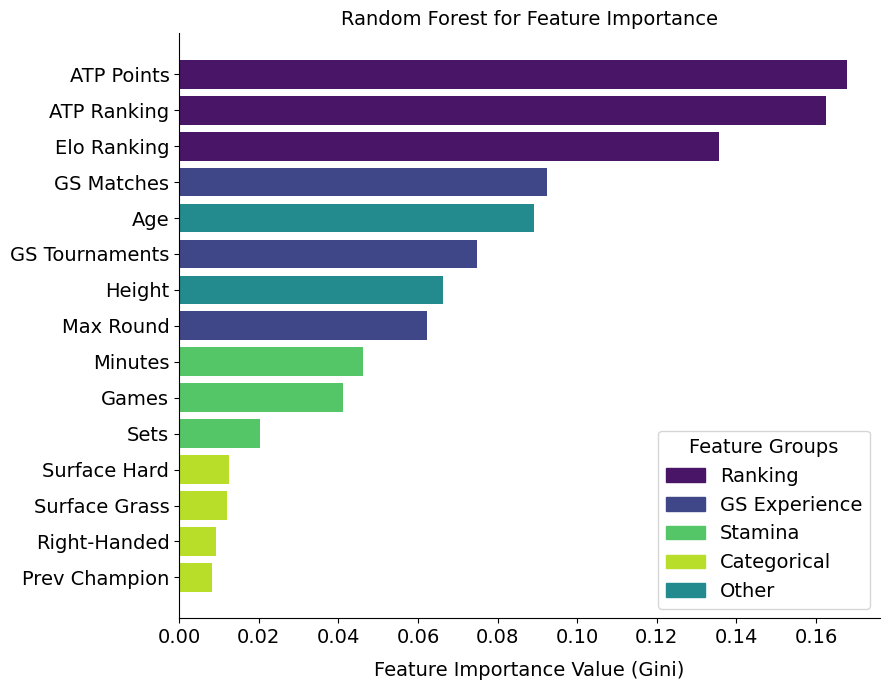

In [26]:
# Rndom forest fit and plot to select best drivers based on feature importance

# Helper function to plot feature importance with category-based colors
def plot_feature_importance(importance_df, title):
    """Create a horizontal bar plot with feature groups in distinct colors."""

    # Define feature groups
    ranking_vars = ['ATP Ranking', 'ATP Points','Elo Ranking']
    prior_exp_vars = ['Max Round', 'GS Tournaments','GS Matches']
    stamina_vars = ['Minutes', 'Sets', 'Games']
    categorical_vars = ['Surface Hard', 'Surface Grass', 'Right-Handed', 'Prev Champion']

    # Define colors for each group
    colors = {'ranking': '#481567FF', 'prior_exp': '#404788FF',      
        'stamina': '#55C667FF', 'categorical': '#B8DE29FF',    
        'other': '#238A8DFF'}

    # Assign a color based on feature category
    def assign_color(feature):
        if feature in ranking_vars:
            return colors['ranking']
        elif feature in prior_exp_vars:
            return colors['prior_exp']
        elif feature in stamina_vars:
            return colors['stamina']
        elif feature in categorical_vars:
            return colors['categorical']
        else:
            return colors['other']

    importance_df['Color'] = importance_df['Feature'].apply(assign_color)

    # Sort by importance for better visualization
    importance_df = importance_df.sort_values(by='Importance', ascending=True)

    # Plot
    plt.figure(figsize=(9,7))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color=importance_df['Color'])
    plt.xlabel('Feature Importance Value (Gini)', fontsize = 14, labelpad =10)
    plt.title(title, fontsize = 14)
    plt.tick_params(axis='y', labelsize=14)
    plt.tick_params(axis='x', labelsize=14)

    # Legend (manual mapping)
    legend_labels = {
        'Ranking': colors['ranking'],
        'GS Experience': colors['prior_exp'],
        'Stamina': colors['stamina'],
        'Categorical': colors['categorical'],
        'Other': colors['other']
    }
    handles = [plt.Rectangle((0, 0), 1, 1, color=c) for c in legend_labels.values()]
    leg = plt.legend( handles,legend_labels.keys(),title="Feature Groups", loc='lower right',fontsize=14)
    leg.get_title().set_fontsize(14)   # size of legend title
    # Remove top and right borders
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    plt.savefig("rf_model.png", dpi=200)
    plt.show()

## Random Forest with (Gini Importance / Mean Decrease in Impurity)

# Fit the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_vf, y_train)

# Extract importance
rf_importance = rf_model.feature_importances_

# Create DataFrame and Plot
rf_importance_df = pd.DataFrame({'Feature': feature_names_desc,'Importance': rf_importance})

plot_feature_importance(rf_importance_df,'Random Forest for Feature Importance')

**Conclusion:** As can be seen, the ranking variables are at the top showing they are the strongest variables. Furthermore, the categorical variables are at the bottom indicating they are the least strong and hence, they will be excluded from the analysis.

#### Select drivers without categorical predictors

In [27]:
selected_drivers = ['Diff_log_ranking', 'Diff_log_ranking_points','Diff_log_Elo',
                    'Diff_tournaments_played','Diff_GS_matches','Diff_Max_round',
                   'Diff_minutes', 'Diff_prev_sets', 'Diff_prev_games',
                    'Diff_age','Diff_height']

#### Variable importance with Logistic Lasso Regression (L1 Regularization)

Lasso Regression to visualise regularisation path within selected drivers

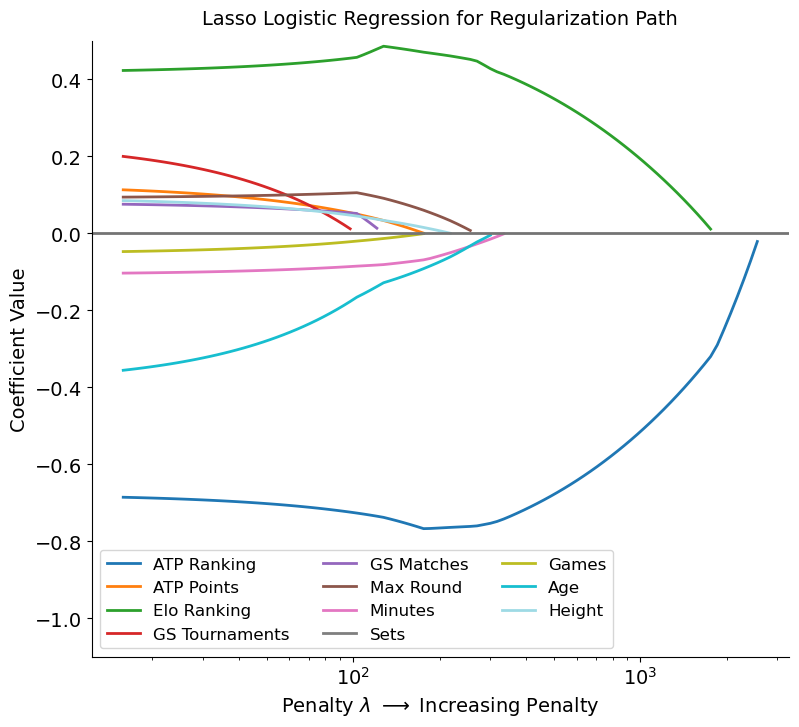

In [28]:
# Compute Regularization Path
# The inverse of the penalty term (lambda): C = 1/lambda.

# Define range of C values (logarithmically spaced)
# Start with a large C (low penalty) and go to a small C (high penalty)
C_values = np.logspace(-3.5, -1.2, 100) # 100 values from 1e-4 to 1e4

# List to store coefficients for each C value
coefs = []

# Iterate over the C values, fit the model, and store the coefficients
for c in C_values:
    # Logistic Regression with L1 penalty (Lasso)
    # Set 'warm_start=True' to reuse the solution from the previous C to speed up computation.
    log_reg_l1 = LogisticRegression( penalty='l1',
        C=c, solver='saga', max_iter=5000,
        random_state=seed, warm_start=True )
    log_reg_l1.fit(X_train_vf[selected_drivers], y_train)
    coefs.append(log_reg_l1.coef_.flatten()) # Store the coefficients
coefs = np.array(coefs)

# Convert C values to the penalty term lambda (lambda = 1/C) to see pattern as lambda increases
lambda_values = 1.0 / C_values

plt.figure(figsize=(9, 8))

# Create a color map with as many unique colors as features
num_features = coefs.shape[1]
#colors = plt.cm.viridis(np.linspace(0, 1, num_features))
colors = plt.cm.tab20(np.linspace(0, 1, 11))

# Plot each coefficient path with a unique color
for i in range(num_features):
    coef_path = np.where(coefs[:, i] == 0, np.nan, coefs[:, i])
    plt.plot(lambda_values, coef_path,
             label=variables_index[selected_drivers[i]],
             color=colors[i],
             linewidth=2)


# Set x-axis to log scale for better visualization of the path
plt.xscale('log')
plt.xlabel('Penalty $\lambda$ $\longrightarrow$ Increasing Penalty', fontsize = 14)
plt.ylabel('Coefficient Value', fontsize = 14)
plt.tick_params(axis='y', labelsize=14)
plt.tick_params(axis='x', labelsize=14)
plt.ylim(-1.1,.5) #y axis limit

plt.title('Lasso Logistic Regression for Regularization Path', fontsize = 14, pad = 12)
leg = plt.legend(loc='lower left', fontsize=12, ncol=3)
#leg.get_frame().set_alpha(1) 

# Remove top and right borders
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.axhline(y=0, color="#747474", linewidth= 2)
plt.savefig("lasso.png", dpi=200)
plt.show()

**Conclusion:** As can be seen, as the penalty term increases, the first variables to be shrunk toward zero are the Sets and GS tournaments whereas ATP ranking and Elo are the last. However, the order in importance differ from Random Forest and this could be due to multicolinearity among predictors, especially from variables within the same category. Therefore, only the best predictor for each category will be selected for the final model based on the Random Fores.

Following this logic, the next drivers are selected considering the Random Forest plot:
- For Ranking: Difference in ATP ranking points (Log)
- For GS Experience: Difference in previous GS matches played
- For Stamina Level: Difference in minutes played in current tournament
- Other variables: Difference in age and difference in height


In [29]:
selected_drivers = [ 'Diff_log_ranking_points','Diff_GS_matches','Diff_age','Diff_minutes','Diff_height']

### Final model with Logistic Regression

In order to have a more robust and specific measure of importance for each variable, a final logistic regression was fit with the selected drivers

In [30]:
# Add constant term (intercept) for Regression required with Stats model package
X_train_sm = sm.add_constant(X_train_vf[selected_drivers],has_constant='add')
X_test_sm = sm.add_constant(X_test_vf[selected_drivers], has_constant='add')

# Fit logistic regression using statsmodels
logit_model = sm.Logit(y_train, X_train_sm)
result = logit_model.fit()

# Print summary with coefficients, p-values, etc.
print(result.summary())

# Compute Predictions
y_pred_prob_train = result.predict(X_train_sm)
y_pred_train = (y_pred_prob_train > 0.5).astype(int)
y_pred_prob_test = result.predict(X_test_sm)
y_pred_test = (y_pred_prob_test > 0.5).astype(int)

# Print summary metrics
print()
print('_____ Logistic Regression metrics _____')
print('**Train Sample**')
print_metrics(y_train, y_pred_train, y_pred_prob_train)
print('**Test Sample**')
print_metrics(y_test, y_pred_test, y_pred_prob_test)

Optimization terminated successfully.
         Current function value: 0.544069
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                10668
Model:                          Logit   Df Residuals:                    10662
Method:                           MLE   Df Model:                            5
Date:                Mon, 24 Nov 2025   Pseudo R-squ.:                  0.2151
Time:                        13:33:20   Log-Likelihood:                -5804.1
converged:                       True   LL-Null:                       -7394.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.0134      0.023      0.595      0.552      -0.031   

**Conclusion:** As can be seen, all drivers (other than the incercept) are statistically significant at a 5% level of significance. Furthermore, the sign of each coefficient is consistent with the expected sign for the driver, e.g. Difference in ATP ranking points (Log) should have a positive sign since a positive difference should increase the probability of winning the match. Finally, this model has a 72.26% in the Train Sample and 71.07% in the Test sample, showing a good performance for a model of this type. The next table shows more details about each specific coefficient, considering their individual contribution to the model, computed as $\dfrac{B_i}{\sum_{j} B_j}$.

In [31]:
# Create summary DataFrame
coef_summary = pd.DataFrame({
    'Feature': result.params.index,
    'Coefficient': result.params.values,
    'P_value': result.pvalues.values
})

# Exclude intercept
coef_summary = coef_summary[coef_summary['Feature'] != 'const']

# Compute absolute coefficient and relative weight
coef_summary['Abs_Coefficient'] = coef_summary['Coefficient'].abs()
coef_summary['Weight_%'] = (
    coef_summary['Abs_Coefficient'] / coef_summary['Abs_Coefficient'].sum() * 100
)

# Sort by descending importance
coef_summary['Feature'] = [variables_index[x] for x in coef_summary['Feature']]
coef_summary = coef_summary.sort_values(by='Weight_%', ascending=False)
coef_summary

,Feature,Coefficient,P_value,Abs_Coefficient,Weight_%
1,ATP Points,0.949871,5.344281e-167,0.949871,40.244939
2,GS Matches,0.717635,5.004368e-63,0.717635,30.405372
3,Age,-0.435130,2.338951e-47,0.435130,18.435967
4,Minutes,-0.141906,1.036151e-08,0.141906,6.012375
5,Height,0.115683,2.794795e-07,0.115683,4.901346


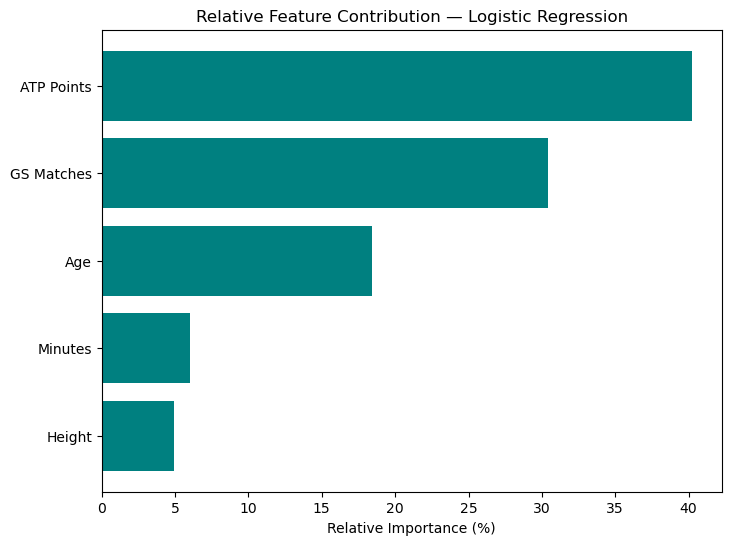

In [32]:
#Plot of %importance
plt.figure(figsize=(8,6))
plt.barh(coef_summary['Feature'], coef_summary['Weight_%'], color='teal')
plt.xlabel('Relative Importance (%)')
plt.title('Relative Feature Contribution — Logistic Regression')
plt.gca().invert_yaxis()
plt.show()

**Conclusion:** As can be seen the most important driver is the Difference in ATP ranking points (Log) with a weight of about 40%, followed by the Difference in GS matches played with a weight of about 30%. Hence only these two variables have a combined weight of about 70%, indicating that they are extremely important to predict tennis math outcomes in GS tournaments.

#### Check of Variance Inflation Factor to review multicolinearity 

In [33]:
#### Check of VIF for multicollinearity
X = X_train_vf[selected_drivers]  # predictors only
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

,Variable,VIF
0,Diff_log_ranking_points,1.576090
1,Diff_GS_matches,2.278842
2,Diff_age,1.614969
3,Diff_minutes,1.057204
4,Diff_height,1.013675


**Conclusion:** As can be seen, all variables have a VIF lower than 3, indicating there is no significant multicollinearity among the predictors and hence, the variables are not highly correlated with each other, suggesting the estimates are stable and reliable.

### ELO Benchmark model

In [34]:
y_pred_prob_train = np.array(full_db_prep[full_db_prep['Sample']=='Train']['Elo_Pi'])
y_pred_train = np.array(y_pred_prob_train>.5)
y_pred_prob_test = np.array(full_db_prep[full_db_prep['Sample']=='Test']['Elo_Pi'])
y_pred_test = np.array(y_pred_prob_test>.5)

print('_____ ELO metrics _____')
print('**Train Sample**')
print_metrics(y_train, y_pred_train, y_pred_prob_train)
print('**Test Sample**')
print_metrics(y_test, y_pred_test, y_pred_prob_test)

_____ ELO metrics _____
**Train Sample**
Accuracy: 0.6942, Calibration: 0.9928, Log_loss: 0.5724
**Test Sample**
Accuracy: 0.6647, Calibration: 1.005, Log_loss: 0.5987


#### Final conclusion

As can be seen, the final logisit regression model outperformed the elo benchmark as the logisitc one showed a higher accuracy (71.07% vs 66.47%)   and a lower loss ( 0.5456 vs 0.5987) on Test sample. Furthermore, the calibration metric for both models is close to 1 indicating that for both models the predicted probabilities align well with the observed outcomes. For all these reasons it can be concluded the final model its actually a useful model for tennis match prediction.